In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
import json

# Create dataset

In [2]:
nft_transactions = pd.read_csv('data/Data_primary_sales.csv', index_col=0)
image_names = pd.read_csv('data/image_names.csv')
median_prices = pd.read_csv('data/median_price_week_1.csv', index_col=0)
visual_features_vgg16 = pd.read_csv(f'data/vgg16_PCA_features7.csv', index_col=0)
visual_features_resnet = pd.read_csv('data/resnet50_PCA_features7.csv', index_col=0)
visual_features_efficient = pd.read_csv('data/EfficientNetV2M_PCA.csv', index_col=0)
centrality_features = pd.read_csv('data/nft_transactions_with_centrality_with_index.csv', index_col=0)
subcols=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection','centrality_seller','centrality_buyer']
centrality_features = centrality_features[subcols].copy()
p_resale = pd.read_csv('data/p_resale.csv', index_col=0)

/var/folders/9t/frr8qwnd5h1_3mymt9gwrcm40000gn/T/ipykernel_22181/2617003772.py:1: DtypeWarning: Columns (2,3,4,6,8,10,11,12,16,17,22) have mixed types. Specify dtype option on import or set low_memory=False.
  nft_transactions = pd.read_csv('data/Data_primary_sales.csv', index_col=0)


In [3]:
nft_transactions.Datetime_updated = pd.to_datetime(nft_transactions.Datetime_updated)
centrality_features.Datetime_updated = pd.to_datetime(centrality_features.Datetime_updated)
median_prices.Datetime_updated = pd.to_datetime(median_prices.Datetime_updated)
centrality_features.drop_duplicates(subset=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection'], inplace=True)
  
to_remove = visual_features_vgg16[visual_features_vgg16.iloc[:,0] == 0].index
visual_features_vgg16.drop(to_remove, inplace=True)    
visual_features_vgg16['image_name'] = visual_features_vgg16.index

to_remove = visual_features_resnet[visual_features_resnet.iloc[:,0] == 0].index
visual_features_resnet.drop(to_remove, inplace=True)    
visual_features_resnet['image_name'] = visual_features_resnet.index

to_remove = visual_features_efficient[visual_features_efficient.iloc[:,0] == 0].index
visual_features_efficient.drop(to_remove, inplace=True)    
visual_features_efficient['image_name'] = visual_features_efficient.index

nft_transactions['image_name'] = image_names['image_name']

In [4]:
combined_data = (nft_transactions
  .merge(median_prices, on=['Datetime_updated','Collection_cleaned'], how='left')
  .merge(visual_features_resnet, on='image_name', how='left')
  .merge(visual_features_vgg16, on='image_name', how='left')
  .merge(visual_features_efficient, on='image_name', how='left')
  .merge(centrality_features.loc[:,subcols], on=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection'], how='left'))

In [11]:
print(len(combined_data))
#print(combined_data.columns)
#import sys
#sys.exit(1)

df_filtered = combined_data.copy()
# drop null Price_USD rows
df_filtered.drop(df_filtered[df_filtered['Price_USD'].isna()].index, inplace=True)
# drop null median price rows
df_filtered.drop(df_filtered[df_filtered['week_1'].isna()].index, inplace=True)
print(len(df_filtered))

df_filtered.drop(['Image_url_1', 'Image_url_2', 'Image_url_3', 'Image_url_4', 'Permanent_link'], axis=1, inplace=True)
df_filtered.drop_duplicates(subset=['image_name'], inplace=True)

print(len(df_filtered))
print(df_filtered.columns)
df_filtered.to_excel("tempim.xlsx")

4678527
4606343
990621
Index(['index', 'Smart_contract', 'ID_token', 'Transaction_hash',
       'Seller_address', 'Seller_username', 'Buyer_address', 'Buyer_username',
       'Price_Crypto', 'Crypto', 'Price_USD', 'Name', 'Description',
       'Collection', 'Market', 'Datetime_updated', 'Datetime_updated_seconds',
       'Unique_id_collection', 'Collection_cleaned', 'Category', 'image_name',
       'week_1', '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '0_y', '1_y',
       '2_y', '3_y', '4_y', '5_y', '6_y', '0', '1', '2', '3', '4', '5', '6',
       'centrality_seller', 'centrality_buyer'],
      dtype='object')


In [45]:
combined_data.head(10000)

,index,Smart_contract,ID_token,Transaction_hash,Seller_address,Seller_username,Buyer_address,Buyer_username,Image_url_1,Image_url_2,...,6_y,0,1,2,3,4,5,6,centrality_seller,centrality_buyer
0,0,NaN,87094722.0,0xed9ff1c311a611e5c457ce0a49bbbb7ed55efca98842...,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0xe0fb7622091e3d9ef9b438471b10b9ea88c7cf6b,NaN,https://card.godsunchained.com/?id=33&q=4,NaN,...,8.848661,-3.093087,0.283622,1.730574,-0.095829,-0.834625,0.323648,0.880614,0.060153,0.001268
1,1,NaN,73044643.0,0xbc8412594ffa7382e8306215ece5b4e041fc641b1813...,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0x2c00d05ff7ffe93d77145dfe12aa56e622ae6f40,NaN,https://card.godsunchained.com/?id=79&q=4,NaN,...,5.874319,-3.412786,-0.370806,1.961081,-1.039890,-0.991484,-0.012637,0.866971,0.060153,0.000431
2,2,NaN,17107482.0,0x92672baf5e9e23de230dee8e57ddf443ab6d5a336341...,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0xe0fb7622091e3d9ef9b438471b10b9ea88c7cf6b,NaN,https://card.godsunchained.com/?id=33&q=4,NaN,...,8.848661,-3.093087,0.283622,1.730574,-0.095829,-0.834625,0.323648,0.880614,0.060153,0.001268
3,3,NaN,82230857.0,0x3d157249e3083622c2d756f07a05caa3a76687288b32...,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0x2c00d05ff7ffe93d77145dfe12aa56e622ae6f40,NaN,https://card.godsunchained.com/?id=227&q=4,NaN,...,7.305613,-3.026390,0.262084,2.031854,0.455307,-0.782484,0.485025,1.027610,0.060153,0.000431
4,4,NaN,40925443.0,0xa892b3569dc8e6b3c7db93aade62372637ebbc61fb63...,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0x2c00d05ff7ffe93d77145dfe12aa56e622ae6f40,NaN,https://card.godsunchained.com/?id=62&q=4,NaN,...,7.236298,-2.882816,0.348495,2.287875,0.631947,-0.762286,0.222104,1.194227,0.060153,0.000431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,10376,NaN,14774401.0,0x97ef6cdede1fd98b3b972fe8ae9193d4269f5c3de2d2...,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0x837ed29de4cab664c550b721bf26dfc028ef6689,NaN,https://card.godsunchained.com/?id=277&q=4,NaN,...,7.379064,2.884820,0.997579,-1.128738,2.463755,-0.789861,-0.041360,0.301611,0.054208,0.000797
9996,10377,NaN,88505760.0,0x8c956c7f7c3cb0117d663e685ff6a6de8ab5de78b3c0...,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0x837ed29de4cab664c550b721bf26dfc028ef6689,NaN,https://card.godsunchained.com/?id=277&q=4,NaN,...,7.118611,2.599995,1.239249,-0.377456,0.502345,-0.405020,-2.813103,1.889259,0.054208,0.000797
9997,10378,NaN,14042542.0,0x6f5e0cd03e2c12ca99ae29ce0a80e21aaf1be435f697...,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0x837ed29de4cab664c550b721bf26dfc028ef6689,NaN,https://card.godsunchained.com/?id=277&q=4,NaN,...,-4.421387,2.875657,0.671693,-1.646227,2.458200,-0.971188,-0.242470,-0.549747,0.054208,0.000797
9998,10379,NaN,93574835.0,0x4a6ec200033813b45e85a5cf21f9d0eb725244a3f1d7...,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0x837ed29de4cab664c550b721bf26dfc028ef6689,NaN,https://card.godsunchained.com/?id=277&q=4,NaN,...,7.588402,-3.033289,-0.149293,2.023096,-0.530984,-0.718886,0.155359,0.854350,0.054208,0.000797


In [46]:
print(combined_data.columns)
print(len(combined_data))

import sys
sys.exit(1)

combined_data.dropna(inplace=True)
print(len(combined_data))

# remove secondary sales
#combined_data.sort_values('Datetime_updated').drop_duplicates('Unique_id_collection', inplace=True)
# remove outlier prices
combined_data.drop(combined_data[combined_data.Price_USD > 10000].index, inplace = True)
print(len(combined_data))

Index(['index', 'Smart_contract', 'ID_token', 'Transaction_hash',
       'Seller_address', 'Seller_username', 'Buyer_address', 'Buyer_username',
       'Image_url_1', 'Image_url_2', 'Image_url_3', 'Image_url_4',
       'Price_Crypto', 'Crypto', 'Price_USD', 'Name', 'Description',
       'Collection', 'Market', 'Datetime_updated', 'Datetime_updated_seconds',
       'Permanent_link', 'Unique_id_collection', 'Collection_cleaned',
       'Category', 'image_name', 'week_1', '0_x', '1_x', '2_x', '3_x', '4_x',
       '5_x', '6_x', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '0', '1',
       '2', '3', '4', '5', '6', 'centrality_seller', 'centrality_buyer'],
      dtype='object')
4678527


SystemExit: 1

/Users/emresefer/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [11]:
# drop 0 valued image features
combined_data.drop(combined_data[combined_data['0_x'] == 0].index, inplace = True)
combined_data.drop(combined_data[combined_data['0_y'] == 0].index, inplace = True)
# drop all nan
combined_data.dropna(inplace=True)
# remove secondary sales
#combined_data.sort_values('Datetime_updated').drop_duplicates('Unique_id_collection', inplace=True)
# remove outlier prices
combined_data.drop(combined_data[combined_data.Price_USD > 10000].index, inplace = True)

In [12]:
df = combined_data

## Define functions

In [12]:
def prepare_primary_sale_data():
  # read in data
  df_primary_sales = pd.read_csv(f'data/Data_primary_sales.csv', index_col=0)
  #df_visual_features = pd.read_csv(f'{folder}resnet50/resnet50PCA_features.csv', index_col=0) 
  #df = pd.read_csv('drive/MyDrive/training/secondary_sale_dataset.csv')
  df_visual_features = pd.read_csv(f'data/EfficientNetV2M_PCA.csv', index_col=0)
  median_prices = pd.read_csv(f'data/median_price_week_1.csv', index_col=0)
  p_resale = pd.read_csv('data/p_resale.csv', index_col=0)
  centrality_features = pd.read_csv(f'data/nft_transactions_with_centrality_with_index.csv', usecols=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection','centrality_seller','centrality_buyer'])
  df_visual_features['image_name'] = df_visual_features.index
  # merge p_resale features with primary sales
  df_primary_sales = pd.merge(df_primary_sales, p_resale, how='left', left_on='index', right_index=True)
  # merge median price features with primary sales
  df_primary_sales.Datetime_updated = pd.to_datetime(df_primary_sales.Datetime_updated)
  median_prices.Datetime_updated = pd.to_datetime(median_prices.Datetime_updated)
  df_primary_sales = pd.merge(df_primary_sales, median_prices, how='left', on=['Datetime_updated', 'Collection_cleaned'])
  # merge centrality features with primary sales
  centrality_features.Datetime_updated = pd.to_datetime(centrality_features.Datetime_updated)
  centrality_features.drop_duplicates(subset=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection'], inplace=True)
  df_primary_sales = pd.merge(df_primary_sales, centrality_features, how='left', 
                              on=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection'])
  # drop unnecesary columns (to save space in the ram)
  df_primary_sales.drop(df_primary_sales.columns.difference(['Category','Price_USD','image_name','week_1','centrality_seller','centrality_buyer','p_resale','Unique_id_collection']), axis=1, inplace=True)
  # remove rows in visual features (this means the image was not processed correctly(image was not downloaded etc.))
  resnet50 = pd.read_csv(f'data/resnet50_PCA_features7.csv', index_col=0)
  to_remove = resnet50[resnet50.iloc[:,0] == 0].index
  df_visual_features.drop(to_remove, inplace=True)
  # drop corresponding missing rows from primary sales
  df_primary_sales.drop(df_primary_sales[~df_primary_sales['image_name'].isin(df_visual_features['image_name'])].index, inplace=True)
  # merge visual features with primary sales
  df_filtered = pd.merge(df_primary_sales, df_visual_features, on=['image_name'], how='left')
  #df_filtered.drop(['image_name'], axis=1, inplace=True)
  # drop null Price_USD rows
  df_filtered.drop(df_filtered[df_filtered['Price_USD'].isna()].index, inplace=True)
  # drop null median price rows
  df_filtered.drop(df_filtered[df_filtered['week_1'].isna()].index, inplace=True)
  # drop duplicate image_name rows
  #df_filtered.drop_duplicates(subset=['image_name'], inplace=True)
  return df_filtered

def split_categories(df):
  categorized_data = {}
  for category in df['Category'].unique():
    categorized_data[category] = {
        'df': df[df['Category'] == category]
    }
  categorized_data['All'] = {
      'df' : df
  }
  return categorized_data

### Algorithms

In [13]:
def linear_regression():
    return LinearRegression()

def linear_svr():
    return LinearSVR(random_state=0, tol=1e-5, verbose=True)

def random_forest_regressor():
    # {'bootstrap': True, 'criterion': 'mse', 'max_depth': 5, 'n_estimators': 1000}
    return RandomForestRegressor(max_depth=5, random_state=0, criterion='squared_error', n_jobs=-1, bootstrap=True, verbose=True)

def ada_boost_regressor():
    return AdaBoostRegressor(random_state=0, n_estimators=100, loss='square')

algorithms = {
    'linear_regression': linear_regression,
    'linear_svr': linear_svr,
    'random_forest_regressor': random_forest_regressor,
    'ada_boost_regressor': ada_boost_regressor
}

## Prepare data

In [14]:
df2 = prepare_primary_sale_data()

/var/folders/9t/frr8qwnd5h1_3mymt9gwrcm40000gn/T/ipykernel_22181/819027393.py:3: DtypeWarning: Columns (2,3,4,6,8,10,11,12,16,17,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_primary_sales = pd.read_csv(f'data/Data_primary_sales.csv', index_col=0)


In [18]:
print(len(df2))
print(df2.columns)
df_filtered = df2.copy()
#df_filtered.drop_duplicates(inplace=True)
df_filtered.drop_duplicates(subset=['image_name', 'Price_USD'], inplace=True)
print(len(df_filtered))

df_filtered.to_csv("tempim2.csv")

3376194
Index(['Price_USD', 'Unique_id_collection', 'Category', 'image_name',
       'p_resale', 'week_1', 'centrality_seller', 'centrality_buyer', '0', '1',
       '2', '3', '4', '5', '6'],
      dtype='object')
2358894


In [22]:
df = pd.read_csv('data/all.csv')

In [23]:
#df.merge(secondary_sales, on='Unique_id_collection', how='left').loc[400000:,['Unique_id_collection','Price_USD','secondary_sale']].rename(columns={'Unique_id_collection':'Unique NFT ID','Price_USD':'Primary Sale Price','secondary_sale':'Secondary Sale'}).set_index('Unique NFT ID').head()

NameError: name 'secondary_sales' is not defined

In [ ]:
#df.to_csv('data/all.csv')

In [24]:
def subset_by_iqr(df, column, whisker_width=1.5):
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]

df = subset_by_iqr(df, 'Price_USD')

In [25]:
df_original = df.copy(deep=True)

In [26]:
std = df_original.Price_USD.std()
mean = df_original.Price_USD.mean()
print(mean - 3 * std, mean + 2 * std)
q25, q75 = np.percentile(df_original.Price_USD, 25), np.percentile(df_original.Price_USD, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print(lower, upper)

-17.912247483849022 19.18101463889701
Percentiles: 25th=0.200, 75th=4.472, IQR=4.272
-6.207909999999998 10.879226


<Axes: >

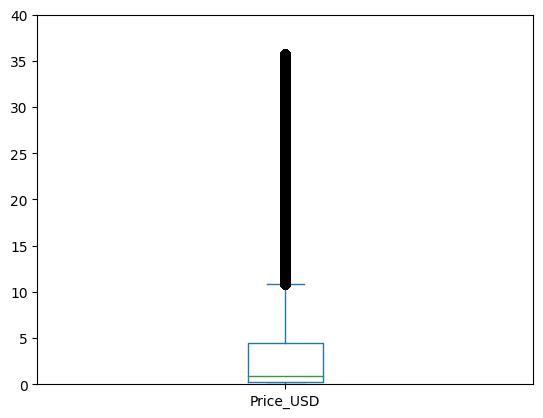

In [27]:
df_original.Price_USD.plot(kind='box', ylim=(0,40))

In [28]:
df_original.Price_USD.describe().map('{:.20f}'.format)

count    2822492.00000000000000000000
mean           4.34370978979859678759
std            7.41865242454920625903
min            0.00000000000000015143
25%            0.19976599999999999913
50%            0.88231979261562698547
75%            4.47154999999999969162
max           35.72597987239583261498
Name: Price_USD, dtype: object

In [29]:
pd.DataFrame.from_dict({'max':7501893.000,'mean':131.624,'std':6430.506,'75%':14.455},'index')

,0
max,7501893.000
mean,131.624
std,6430.506
75%,14.455


In [30]:
df_original.Price_USD.describe()

count    2.822492e+06
mean     4.343710e+00
std      7.418652e+00
min      1.514250e-16
25%      1.997660e-01
50%      8.823198e-01
75%      4.471550e+00
max      3.572598e+01
Name: Price_USD, dtype: float64

In [31]:
df_original['index_col'] = df_original.reset_index().index

In [32]:
# first 95% of the prices
stds = np.full(df_original.shape[0], df_original.Price_USD.std() * 2 + df_original.Price_USD.mean())
xs = np.arange(0,df_original.shape[0])

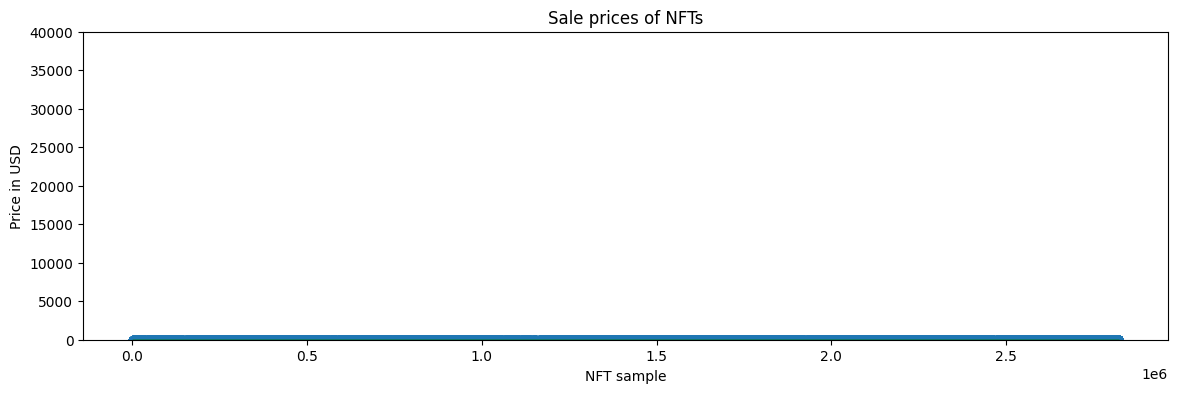

In [33]:
fig, ax = plt.subplots(figsize=(14, 4))
plt.title('Sale prices of NFTs')
df_original.rename(columns={'Price_USD':'Price in USD','index_col':'NFT sample'}).plot(kind='scatter',x='NFT sample',y='Price in USD',ylim=(0,40000),ax=ax)
ax.fill_between(xs, stds, alpha=0.4,color='green')

In [34]:
df_original[df_original.Price_USD > 35.72598188568845].shape[0]

0

In [35]:
#df.drop(df[df.Price_USD > 35.72598188568845].index, inplace=True)
# DROPPING NAN HEREEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
#df.dropna(inplace=True)
categorized_data = split_categories(df)
feature_columns = ['0','1','2','3','4','5','6','week_1','centrality_seller','centrality_buyer','p_resale']
label_column = 'Price_USD'
for key, item in categorized_data.items():
  category_df = item['df']
  X_ = category_df[feature_columns].values
  y_ = category_df[label_column].values
  #X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.08, random_state=42)
  #categorized_data[key]['X_train'] = X_train
  #categorized_data[key]['X_test'] = X_test
  #categorized_data[key]['y_train'] = y_train
  #categorized_data[key]['y_test'] = y_test
  X, X_test, y, y_test = train_test_split(X_,y_,test_size=0.2,train_size=0.8)
  X_train, X_validation, y_train, y_validation = train_test_split(X,y,test_size = 0.25,train_size =0.75)
  categorized_data[key]['X_train'] = X_train
  categorized_data[key]['X_test'] = X_test
  categorized_data[key]['y_train'] = y_train
  categorized_data[key]['y_test'] = y_test
  categorized_data[key]['X_validation'] = X_validation
  categorized_data[key]['y_validation'] = y_validation

In [36]:
for key, item in categorized_data.items():
  print(f'{key}\n\tTrain count: {len(item["X_train"]):,}\n\tTest count: {len(item["X_test"]):,}\n\tValidation count: {len(item["X_validation"]):,}')

Games
	Train count: 752,625
	Test count: 250,876
	Validation count: 250,875
Art
	Train count: 356,308
	Test count: 118,770
	Validation count: 118,770
Other
	Train count: 53,100
	Test count: 17,701
	Validation count: 17,701
Collectible
	Train count: 520,026
	Test count: 173,342
	Validation count: 173,342
Utility
	Train count: 1,701
	Test count: 568
	Validation count: 567
Metaverse
	Train count: 9,732
	Test count: 3,244
	Validation count: 3,244
All
	Train count: 1,693,494
	Test count: 564,499
	Validation count: 564,499


## Old way

In [37]:
X = df[feature_columns].values
y = df[label_column].values
x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_scaler.fit(X)
y_scaler.fit(y.reshape(-1, 1))
X = x_scaler.transform(X)
y = y_scaler.transform(y.reshape(-1, 1)).reshape(df.shape[0],)
x_minmax_scaler = MinMaxScaler()
y_minmax_scaler = MinMaxScaler()
X = x_minmax_scaler.fit_transform(X)
y = y_minmax_scaler.fit_transform(y.reshape(-1, 1)).reshape(df.shape[0],)
df[feature_columns] = X
df[label_column] = y


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08, random_state=42)
# print(f'\n{len(X_train)} training, {len(X_test)} test samples')
# categorized_data = split_categories(df)
# for category, category_data in categorized_data.items():
#   print(f'\n{category} category: {category_data["df"].shape[0]} samples')
# plt.title("Number of Samples", fontsize=14)
# plt.bar(x=df.Category.value_counts().index,
#         height=df.Category.value_counts().values)

In [38]:
import seaborn as sns
df_corr = df.dropna().corr(method ='pearson')
cm = sns.light_palette("green", as_cmap=True)
s = df_corr.style.background_gradient(cmap=cm)
s

ValueError: could not convert string to float: 'Games'

## Visualize

ValueError: could not convert string to float: 'Games'

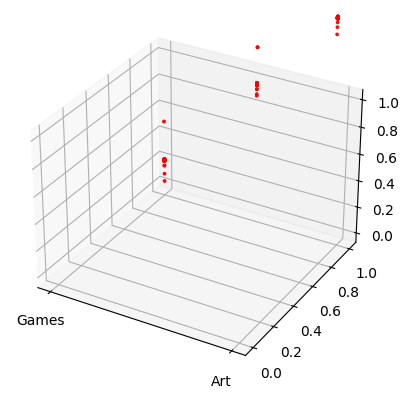

In [39]:
colors = {
    'Games': 'red',
    'Art': 'green',
    'Other': 'blue',
    'Collectible': 'yellow',
    'Metaverse': 'pink',
    'Utility': 'purple'
}

X = df.iloc[::6]
color_list = X.dropna(subset=['Category'])['Category'].map(colors).values
values = X.iloc[:,2:].values

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(values[:,0], values[:,1], values[:,2], c=color_list, s=3)

In [ ]:
import plotly.graph_objs as go
nth = 100

categories = X.dropna(subset=['Category'])['Category']
layout = go.Layout(
    legend=dict(
        x=1,
        y=1
    ),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=go.layout.Scene(
      xaxis=go.layout.scene.XAxis(title='1st Principle Component'),
      yaxis=go.layout.scene.YAxis(title='2nd Principle Component'),
      zaxis=go.layout.scene.ZAxis(title='3rd Principle Component')
    )
)

fig = go.Figure(layout=layout)

for category in categories.unique():
  dfp = categories[categories==category][::6]
  print(category)
  print(dfp.shape)
  print(dfp.index)
  fig.add_trace(go.Scatter3d(
    x=X.loc[dfp.index,'2'].values,
    y=X.loc[dfp.index,'3'].values,
    z=X.loc[dfp.index,'4'].values,
    mode = 'markers',
    name=category,
    marker = dict(
      size=2,
      color=colors[category],
      opacity=1,
    )
  ))

fig.show()

## Fit

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth":    [4, 5, 7, 9],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015, 0.03]}

regressor = xgb.XGBRegressor(tree_method='gpu_hist', objective='reg:squarederror')
search = GridSearchCV(regressor, param_grid, cv=5).fit(categorized_data['Art']['X_train'], categorized_data['Art']['y_train'])

print("The best hyperparameters are ",search.best_params_)

In [ ]:
print("The best hyperparameters are ",search.best_params_)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_validate
regressor=xgb.XGBRegressor(tree_method="gpu_hist",
                           n_estimators  = 500,
                           colsample_bytree=0.6592393666880914,
                           gamma= 0.8949857773840227,
                           learning_rate= 0.13225793236639394,
                           max_bin= 439,
                           max_depth= 5,
                           min_child_weight= 0.1108374927273914,
                           reg_alpha= 38.28551235131752,
                           reg_lambda= 43.81714225406587,
                           objective='reg:squarederror')

folds = 5
results = pd.DataFrame(columns=[f'fold{i+1}' for i in range(folds)], index=categorized_data.keys())
#feature_importances = pd.DataFrame(columns=[f'fold{i+1}' for i in range(folds)], index=categorized_data.keys())
#results = {}
for category in categorized_data.keys():
  #scores = cross_val_score(regressor, categorized_data[category]['X_train'], categorized_data[category]['y_train'], scoring='r2', cv=folds)
  #results.loc[category] = scores
  X_train = categorized_data[category]['X_train']
  y_train = categorized_data[category]['y_train']
  X_validation = categorized_data[category]['X_validation']
  y_validation = categorized_data[category]['y_validation']
  fit_params = {
      'eval_set':[(X_train, y_train), (X_validation, y_validation)],
      'early_stopping_rounds':5
  }
  results.loc[category] = cross_validate(regressor, categorized_data[category]['X_train'], categorized_data[category]['y_train'], cv=folds, scoring = 'r2', return_estimator=False, return_train_score=True, fit_params=fit_params)['test_score']

In [ ]:
results.mean(axis=1)

In [ ]:
results.mean(axis=1)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_validate
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error
from hyperopt.pyll.base import scope

space = {'max_depth': scope.int(hp.quniform("max_depth", 1, 5, 1)),
        'gamma': hp.uniform ('gamma', 0,1),
        'reg_alpha' : hp.uniform('reg_alpha', 0,50),
        'reg_lambda' : hp.uniform('reg_lambda', 10,100),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
        'n_estimators': 2000,
        'learning_rate': hp.uniform('learning_rate', 0, .15),
        'tree_method':'gpu_hist',
        'gpu_id': 0,
        'random_state': 5,
        'max_bin' : scope.int(hp.quniform('max_bin', 200, 550, 1))}

def hyperparameter_tuning(space):
    model = xgb.XGBRegressor(**space)

    X_train = categorized_data['Art']['X_train']
    y_train = categorized_data['Art']['y_train']
    X_validation = categorized_data['Art']['X_validation']
    y_validation = categorized_data['Art']['y_validation']

    #Define evaluation datasets.
    evaluation = [(X_train, y_train), (X_validation, y_validation)]

    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=20,verbose=False)

    #Obtain prediction and rmse score.

    pred = model.predict(X_validation)
    rmse = mean_squared_error(y_validation, pred, squared=False)
    print ("SCORE:", rmse)

    #Specify what the loss is for each model.
    return {'loss':rmse, 'status': STATUS_OK }

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print(best)

#Create instace of best model.
best_model = trials.results[np.argmin([r['loss'] for r in
    trials.results])]

#Examine model hyperparameters
print(best_model)

In [ ]:
regressor=xgb.XGBRegressor(tree_method="gpu_hist",
                           n_estimators  = 5000,
                           colsample_bytree=0.6592393666880914,
                           gamma= 0.8949857773840227,
                           learning_rate= 0.13225793236639394,
                           max_bin= 439,
                           max_depth= 5,
                           min_child_weight= 0.1108374927273914,
                           reg_alpha= 38.28551235131752,
                           reg_lambda= 43.81714225406587,
                           objective='reg:squarederror')
X_train = categorized_data['Art']['X_train']
y_train = categorized_data['Art']['y_train']
X_validation = categorized_data['Art']['X_validation']
y_validation = categorized_data['Art']['y_validation']
eval_set = [(X_train, y_train), (X_validation, y_validation)]
regressor.fit(X_train, y_train, eval_set=eval_set)
pd.DataFrame({key:value['rmse'] for key, value in regressor.evals_result().items()}).rename(columns={'validation_0':'Train','validation_1':'Validation'}).plot()


In [ ]:
results['All']

In [ ]:
results.mean(axis=1)

In [ ]:
results.mean(axis=1)

In [ ]:
df

In [ ]:
results

In [ ]:
results

In [ ]:
results = pd.DataFrame(columns=algorithms.keys(), index=categorized_data.keys())
losses = {}
for category, category_data in categorized_data.items():
  X_train = category_data['X_train']
  y_train = category_data['y_train']
  X_test = category_data['X_test']
  y_test = category_data['y_test']
  print(f'category {category}')
  for alg_name, alg_func in algorithms.items():
    algorithm = alg_func()
    print(f'\tfitting {alg_name}')
    algorithm.fit(X_train, y_train)
    score = algorithm.score(X_test, y_test)
    results.loc[category, alg_name] = score
    losses[category] = {
        'train': algorithm.train_score_,
        'val': algorithm.validation_score_
    }
    if hasattr(algorithm, 'feature_importances_'):
      print(algorithm.feature_importances_)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
fig.text(0.5, 0.04, 'Iterations', ha='center', va='center')
for key, item in losses.items():
  pd.DataFrame(item).loc[:,'train'].rename(key).abs().plot(ax=axes[0], legend=True, ylabel='Train loss')
  pd.DataFrame(item).loc[:,'val'].rename(key).abs().plot(ax=axes[1], legend=True, ylabel='Validation loss')

In [ ]:
results

In [ ]:
results

In [ ]:
results

In [ ]:
results

In [ ]:
results

In [ ]:
results

In [ ]:
results

In [ ]:
results

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
fig.text(0.5, 0.04, 'Iterations', ha='center', va='center')
for key, item in losses.items():
  pd.DataFrame(item).loc[:,'train'].rename(key).abs().plot(ax=axes[0], legend=True, ylabel='Train loss')
  pd.DataFrame(item).loc[:,'val'].rename(key).abs().plot(ax=axes[1], legend=True, ylabel='Validation loss')

In [ ]:
results

In [ ]:
results

In [ ]:
# with 0..6, week_1, centrality
# learning_rate = 0.1
# max_iter = 250
results

In [ ]:
# with 0..6, week_1, centrality
results

In [ ]:
# with 0..6, week_1, centrality
results

In [ ]:
# with 0..6, week_1, centrality
# learning_rate = 0.5
# max_iter = 250
results

In [ ]:
# with 0..6, week_1, centrality
# null centralities dropped
# 0.12 instead of 0.08
# learning_rate = 0.5
# max_iter = 250
results

In [ ]:
# with 0..6, week_1, centrality
# null centralities dropped
# 0.12 instead of 0.08
# learning_rate = 0.9
results

In [ ]:
# with 0..6, week_1, centrality
# null centralities dropped
# 0.12 instead of 0.08
# learning_rate = 0.5
results

In [ ]:
# with 0..6, week_1, centrality
# null centralities dropped
# 0.12 instead of 0.08
results

In [ ]:
# with 0..6, week_1, centrality
# null centralities dropped
results

In [ ]:
# with 0..6, week_1, centrality
results

In [ ]:
# with 0..6, week_1
results

In [ ]:
# with 0..6, week_1, centrality, p_resale
results

In [ ]:
results

In [ ]:
scores = {}
for alg_name, alg_func in algorithms.items():
  algorithm = alg_func()
  print(f'fitting {alg_name}')
  algorithm.fit(X_train, y_train)
  all_score = algorithm.score(X_test, y_test)
  scores[alg_name] = { 'All' : all_score }
  for category, category_df in categorized_data.items():
    X = category_df[feature_columns].values
    y = category_df[label_column].values
    category_score = algorithm.score(X, y)
    scores[alg_name][category] = category_score
  print(algorithm.feature_importances_)
print(json.dumps(scores, indent=4))

In [ ]:
feature_columns

# TEMP STUFF AFTER THIS

In [ ]:
def plot_relationships(df, num_cols):
    variables = df.columns
    # This function assumes that the dependent variable is in the last column
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,30))
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1
plot_relationships(df,8)

In [ ]:
#zamn = 0
#with h5py.File(f'data/resnet50/resnet50_features.h5', 'r') as f:
#  data = f['data']
#  zamn = pd.DataFrame(data)
#  zamn.to_csv('data/resnet50/resnet50_features.csv')

In [ ]:
zamn = 0
with h5py.File(f'data/resnet50/resnet50PCA_features.h5', 'r') as f:
  data = f['data']
  zamn = pd.DataFrame(data)

In [ ]:
feature_folder = 'data/'
df_primary_sales = pd.read_csv(f'{feature_folder}Data_primary_sales.csv', index_col=0)
f = h5py.File(f'{feature_folder}resnet50/resnet50PCA_features.h5', 'r')
df_visual_features = pd.DataFrame(f['data'])
f.close()

In [ ]:
df_visual_features['image_name'] = df_visual_features.index
df_primary_sales = pd.merge(df_primary_sales, df_visual_features, on=['image_name'], how='left')

In [ ]:
df_filtered = df_primary_sales.drop(df_primary_sales[df_primary_sales[0] == 0].index).reset_index()

In [ ]:
X = df_filtered[[0,1,2,3,4,5,6]].values
y = df_filtered['Price_USD'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [ ]:
  folder = 'data/'
  df_primary_sales = pd.read_csv(f'{folder}Data_primary_sales.csv', index_col=0)
  df_visual_features = pd.read_csv(f'{folder}resnet50/resnet50PCA_features.csv', index_col=0)
  # merge visual features with primary sales
  df_visual_features['image_name'] = df_visual_features.index
  df_primary_sales = pd.merge(df_primary_sales, df_visual_features, on=['image_name'], how='left')
  # remove rows with 0 in visual features (this means the image was not processed correctly(image was not downloaded etc.))
  df_filtered = df_primary_sales.drop(df_primary_sales[df_primary_sales[0] == 0].index).reset_index()
  # pick features and label
  X = df_filtered[[0,1,2,3,4,5,6]].values
  y = df_filtered['Price_USD'].values
  # shuffle and split training data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [ ]:
df_filtered = df_primary_sales[~df_primary_sales[['0','1','2','3','4','5','6']].eq(0).sum(1).ge(7)].reset_index()

In [ ]:
X = df_filtered[['0','1','2','3','4','5','6']].values
y = df_filtered['Price_USD'].values

In [ ]:
df_primary_sales[df_primary_sales['Price_USD'].isna()]

In [ ]:
pd.set_option('display.max_columns', None)
df_filtered[df_filtered['Price_USD'].isna()]

In [ ]:
np.argwhere(np.isnan(y))

In [ ]:
!cat data/resnet50/resnet50_batch000.csv | grep 2454,

In [ ]:
!head -n 3000 data/resnet50/resnet50PCA_features.csv | grep '2454,'